# Data Discover and Transformation
in this section of the lab, we'll use Glue to discover new transportation data.  From there, we'll use Athena to query and start looking into the dataset to understand the data we are dealing with.

We've also setup a set of ETLs using Glue to create the fields into a canonical form, since all the fields call names different things.  

After understanding the data, and cleaning it a little, we'll go into another notebook to perform feature engineering and time series modeling.

### What are Databases and Tables in Glue:
When you define a table in the AWS Glue Data Catalog, you add it to a database. A database is used to organize tables in AWS Glue. You can organize your tables using a crawler or using the AWS Glue console. A table can be in only one database at a time.

Your database can contain tables that define data from many different data stores.

A table in the AWS Glue Data Catalog is the metadata definition that represents the data in a data store. You create tables when you run a crawler, or you can create a table manually in the AWS Glue console. The Tables list in the AWS Glue console displays values of your table's metadata. You use table definitions to specify sources and targets when you create ETL (extract, transform, and load) jobs. 

In [1]:
import boto3

database_name = '2019reinventWorkshop'

## lets first create a namespace for the tables:
glue_client = boto3.client('glue')
create_database_resp = glue_client.create_database(
    DatabaseInput={
        'Name': database_name,
        'Description': 'This database will contain the tables discovered through both crawling and the ETL processes'
    }
)

This will create a new database, or namespace, that can hold the collection of tables

https://console.aws.amazon.com/glue/home?region=us-east-1#catalog:tab=databases

![create db response](images/createdatabaseresponse.png "")

You can use a crawler to populate the AWS Glue Data Catalog with tables. This is the primary method used by most AWS Glue users. A crawler can crawl multiple data stores in a single run. Upon completion, the crawler creates or updates one or more tables in your Data Catalog. Extract, transform, and load (ETL) jobs that you define in AWS Glue use these Data Catalog tables as sources and targets. The ETL job reads from and writes to the data stores that are specified in the source and target Data Catalog tables. 

In [2]:
crawler_name = '2019reinventworkshopcrawler'
create_crawler_resp = glue_client.create_crawler(
    Name=crawler_name,
    Role='GlueRole',
    DatabaseName=database_name,
    Description='Crawler to discover the base tables for the workshop',
    Targets={
        'S3Targets': [
            {
                'Path': 's3://serverless-analytics/reinvent-2019/taxi_data/',
            },
        ]
    }
)
response = glue_client.start_crawler(
    Name=crawler_name
)

After starting the crawler, you can go to the glue console if you'd like to see it running.

https://console.aws.amazon.com/glue/home?region=us-east-1#catalog:tab=crawlers
![startcrawlerui](images/startcrawlerui.png "")

After it finishes crawling, you can see the datasets (represeted as "tables") it automatically discovered.
![crawler_discovered](images/crawler_discovered.png "")

### Waiting for the Crawler to finish

In [3]:
import time
 
response = glue_client.get_crawler(
    Name=crawler_name
)
while (response['Crawler']['State'] == 'RUNNING') | (response['Crawler']['State'] == 'STOPPING'):
    print(response['Crawler']['State'])
    # Wait for 40 seconds
    time.sleep(40)
    
    response = glue_client.get_crawler(
        Name=crawler_name
    )

print('finished running', response['Crawler']['State'])

RUNNING
RUNNING
STOPPING
STOPPING
finished running READY


## Querying the data

We'll use Athena to query the data.  Athena allows us to perform SQL queries against datasets on S3, without having to transform them, load them into a traditional sql datastore, and allows rapid ad-hoc investigation.  

Later we'll use Spark to do ETL and feature engineering.

In [4]:
!pip install --upgrade pip > /dev/null
!pip install PyAthena > /dev/null

Athena uses S3 to store results to allow different types of clients to read it and so you can go back and see the results of previous queries.  We can set that up next:

In [5]:
import sagemaker
sagemaker_session = sagemaker.Session()
athena_data_bucket = sagemaker_session.default_bucket()

Next we'll create an Athena connection we can use, much like a standard JDBC/ODBC connection

In [6]:
from pyathena import connect
import pandas as pd

sagemaker_session = sagemaker.Session()

conn = connect(s3_staging_dir="s3://" + athena_data_bucket,
               region_name=sagemaker_session.boto_region_name)

df = pd.read_sql('SELECT \'yellow\' type, count(*) ride_count FROM "' + database_name + '"."yellow" ' + 
                 'UNION ALL SELECT \'green\' type, count(*) ride_count FROM "' + database_name + '"."green"' +
                 'UNION ALL SELECT \'fhv\' type, count(*) ride_count FROM "' + database_name + '"."fhv"', conn)
print(df)
df.plot.bar(x='type', y='ride_count')

     type  ride_count
0   green    12105351
1  yellow   147263398
2     fhv   292722358


In [7]:
green_etl = '2019reinvent_green'

response = glue_client.start_job_run(
    JobName=green_etl,
    WorkerType='Standard', # other options include: 'G.1X'|'G.2X',
    NumberOfWorkers=5
)
print('response from starting green')
print(response)

response from starting green
{'JobRunId': 'jr_466ee6fbc9356bdaf875f815035e823c382666cc060e38092fe91d5411ae0546', 'ResponseMetadata': {'RequestId': 'bf2b5ed1-2b2b-11ea-9cf9-c754cb1c941b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 30 Dec 2019 17:42:28 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '82', 'connection': 'keep-alive', 'x-amzn-requestid': 'bf2b5ed1-2b2b-11ea-9cf9-c754cb1c941b'}, 'RetryAttempts': 0}}


After kicking it off, you can see it running in the console too:
https://console.aws.amazon.com/glue/home?region=us-east-1#etl:tab=jobs
<img src="images/ETLStart.png"/>

<b>WAIT UNTIL THE ETL JOB FINISHES BEFORE CONTINUING!</b>
<b>ALSO, YOU MUST CHANGE THE BUCKET PATH IN THIS CELL - FIND THE BUCKET IN S3 THAT CONTAINS '2019reinventetlbucket' in the name</b>

In [8]:
#let's list the s3 bucket name:
!aws s3 ls | grep '2019reinventetlbucket' | head -1

2019-12-30 17:08:43 aim357-template2-2019reinventetlbucket-144yyhe1x8qgo


In [9]:
# syntax should be s3://...
normalized_bucket = 's3://aim357-template2-2019reinventetlbucket-144yyhe1x8qgo'



## DO NOT MODIFY THESE LINES, they are there to ensure the line above is updated correctly
assert(normalized_bucket != 's3://FILL_IN_BUCKET_NAME')
assert(normalized_bucket.startswith( 's3://' ))

create_crawler_resp = glue_client.create_crawler(
    Name=crawler_name + '_normalized',
    Role='GlueRole',
    DatabaseName=database_name,
    Description='Crawler to discover the base tables for the workshop',
    Targets={
        'S3Targets': [
            {
                'Path': normalized_bucket + "/canonical/",
            },
        ]
    }
)
response = glue_client.start_crawler(
    Name=crawler_name + '_normalized'
)


### Let's wait for the next crawler to finish, this will discover the normalized dataset.

In [10]:
import time
 
response = glue_client.get_crawler(
    Name=crawler_name + '_normalized'
)
while (response['Crawler']['State'] == 'RUNNING') | (response['Crawler']['State'] == 'STOPPING'):
    print(response['Crawler']['State'])
    # Wait for 40 seconds
    time.sleep(40)
    
    response = glue_client.get_crawler(
        Name=crawler_name + '_normalized'
    )

print('finished running', response['Crawler']['State'])

RUNNING
STOPPING
STOPPING
finished running READY


## Querying the Normalized Data

Now let's look at the total counts for the aggregated information

    type  ride_count
0  green    12105351


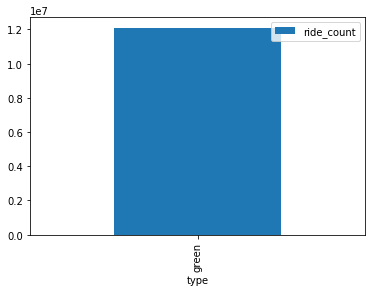

In [11]:
normalized_df = pd.read_sql('SELECT type, count(*) ride_count FROM "' + database_name + '"."canonical" group by type', conn)
print(normalized_df)
normalized_df.plot.bar(x='type', y='ride_count')
#

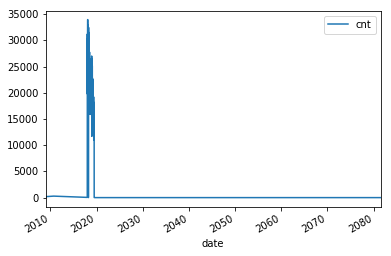

In [12]:
query = "select type, date_trunc('day', pickup_datetime) date, count(*) cnt from \"" + database_name + "\".canonical where pickup_datetime < timestamp '2099-12-31' group by type, date_trunc(\'day\', pickup_datetime) "
typeperday_df = pd.read_sql(query, conn)
typeperday_df.plot(x='date', y='cnt')

## We see some bad data here...
We are expecting only 2018 and 2019 datasets here, but can see there are records far into the future and in the past.  This represents bad data that we want to eliminate before we build our model.


In [13]:
# Only reason we put this conditional here is so you can execute the cell multiple times
# if you don't check, it won't find the 'date' column again and makes interacting w/ the notebook more seemless
if type(typeperday_df.index) != pd.core.indexes.datetimes.DatetimeIndex:
    print('setting index to date')
    typeperday_df = typeperday_df.set_index('date', drop=True)
    
typeperday_df.head()

setting index to date


,type,cnt
date,,
2018-03-18,green,25602
2019-07-01,green,15
2018-06-07,green,25159
2018-06-28,green,24517
2018-06-21,green,25620


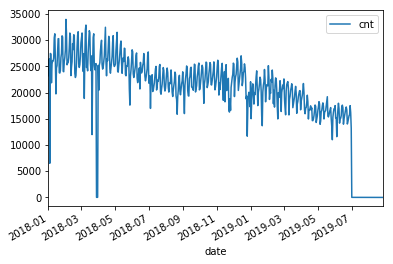

In [14]:
typeperday_df.loc['2018-01-01':'2019-12-31'].plot(y='cnt')

Let's look at some of the bad data now:


All the bad data, at least the bad data in the future, is coming from the yellow taxi license type.

### Note, we are querying the transformed data.

We should check the raw dataset to see if it's also bad or something happened in the ETL process

Let's find the two 2088 records to make sure they are in the source data

In [15]:
pd.read_sql("select * from \"" + database_name + "\".yellow where tpep_pickup_datetime like '2088%'", conn)

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2,2088-01-24 00:15:42,2088-01-24 00:19:46,1,0.63,1,N,41,166,2,4.5,0.0,0.5,0.0,0.0,0.3,5.3,None
1,2,2088-01-24 00:25:39,2088-01-24 07:28:25,1,4.05,1,N,24,162,2,14.5,0.0,0.5,0.0,0.0,0.3,15.3,None


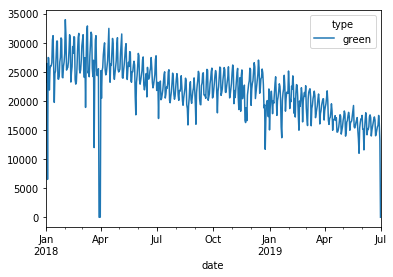

In [16]:
## Next let's plot this per type:
typeperday_df.loc['2018-01-01':'2019-07-30'].pivot_table(index='date', 
                                                         columns='type', 
                                                         values='cnt', 
                                                         aggfunc='sum').plot()

## Fixing our Time Series data

Some details of what caused this drop:
#### On August 14, 2018, Mayor de Blasio signed Local Law 149 of 2018, creating a new license category for TLC-licensed FHV businesses that currently dispatch or plan to dispatch more than 10,000 FHV trips in New York City per day under a single brand, trade, or operating name, referred to as High-Volume For-Hire Services (HVFHS). This law went into effect on Feb 1, 2019

Let's bring the other license type and see how it affects the time series charts:

In [17]:
create_crawler_resp = glue_client.create_crawler(
    Name=crawler_name + '_fhvhv',
    Role='GlueRole',
    DatabaseName=database_name,
    Description='Crawler to discover the base tables for the workshop',
    Targets={
        'S3Targets': [
            {
                'Path': 's3://serverless-analytics/reinvent-2019_moredata/taxi_data/fhvhv/',
            },
        ]
    }
)
response = glue_client.start_crawler(
    Name=crawler_name + '_fhvhv'
)



### Wait to discover the fhvhv dataset...

In [18]:
import time
 
response = glue_client.get_crawler(
    Name=crawler_name + '_fhvhv'
)
while (response['Crawler']['State'] == 'RUNNING') | (response['Crawler']['State'] == 'STOPPING'):
    print(response['Crawler']['State'])
    # Wait for 40 seconds
    time.sleep(40)
    
    response = glue_client.get_crawler(
        Name=crawler_name + '_fhvhv'
    )

print('finished running', response['Crawler']['State'])

RUNNING
RUNNING
STOPPING
STOPPING
STOPPING
STOPPING
finished running READY


             type     cnt
date                     
2019-05-12  fhvhv  857727
2019-03-22  fhvhv  846827
2019-03-08  fhvhv  853746
2019-06-25  fhvhv  651649
2019-03-01  fhvhv  837591


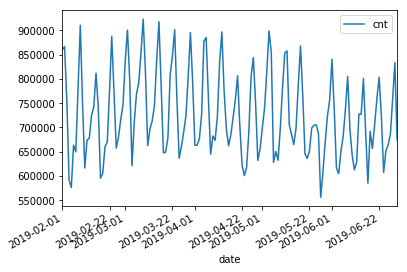

In [19]:
query = 'select \'fhvhv\' as type, date_trunc(\'day\', cast(pickup_datetime as timestamp)) date, count(*) cnt from "' + database_name + '"."fhvhv" group by date_trunc(\'day\',  cast(pickup_datetime as timestamp)) '
typeperday_fhvhv_df = pd.read_sql(query, conn)
typeperday_fhvhv_df = typeperday_fhvhv_df.set_index('date', drop=True)
print(typeperday_fhvhv_df.head())
typeperday_fhvhv_df.plot(y='cnt')

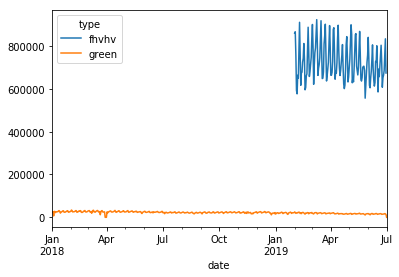

In [20]:
pd.concat([typeperday_fhvhv_df, typeperday_df], sort=False).loc['2018-01-01':'2019-07-30'].pivot_table(index='date', 
                                                         columns='type', 
                                                         values='cnt', 
                                                         aggfunc='sum').plot()

### That looks better -- let's start looking at performing EDA now. Please open the other notebook file in your SageMaker notebook instance.